# MIMIC-IV Data Exploration

This notebook performs Exploratory Data Analysis (EDA) on MIMIC-IV data to understand patient statistics, feature distributions, and dataset complexity. The analysis includes patient demographics, admission patterns, laboratory events, microbiology tests, and chart events (vitals).

**Important Note**: The `chartevents` and `labevents` tables are massive. This notebook uses chunking to avoid Out-Of-Memory errors.

## Section 1: Setup & Configuration

In [1]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict, Counter

# Set plot style for better readability
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Adjust this base path to your MIMIC-IV data directory
#base_path = 'C:\\Users\\Eli\\Data\\physionet.org\\files\\mimiciv\\3.1\\'
base_path = '~/data/physionet.org/files/mimiciv/3.1/'

# Define file paths - update these to match your data location
#patients_file = base_path + 'hosp\\patients.csv.gz'
#admissions_file = base_path + 'hosp\\admissions.csv.gz'
#labevents_file = base_path + 'hosp\\labevents.csv.gz'
#d_labitems_file = base_path + 'hosp\\d_labitems.csv.gz'
#microbiologyevents_file = base_path + 'hosp\\microbiologyevents.csv.gz'
#chartevents_file = base_path + 'icu\\chartevents.csv.gz'
#d_items_file = base_path + 'icu\\d_items.csv.gz'

patients_file = base_path + 'hosp/patients.csv.gz'
admissions_file = base_path + 'hosp/admissions.csv.gz'
labevents_file = base_path + 'hosp/labevents.csv.gz'
d_labitems_file = base_path + 'hosp/d_labitems.csv.gz'
microbiologyevents_file = base_path + 'hosp/microbiologyevents.csv.gz'
chartevents_file = base_path + 'icu/chartevents.csv.gz'
d_items_file = base_path + 'icu/d_items.csv.gz'


print("File paths defined.")

File paths defined.


## Section 2: Patient & Admission Statistics

Load patient and admission data to understand the overall structure of the dataset.

In [3]:
# Load patients table
print("Loading patients table...")
patients_df = pd.read_csv(patients_file)
print(f"Patients loaded: {len(patients_df)} rows")
print(f"Columns: {list(patients_df.columns)}")

Loading patients table...
Patients loaded: 364627 rows
Columns: ['subject_id', 'gender', 'anchor_age', 'anchor_year', 'anchor_year_group', 'dod']


In [4]:
# Load admissions table
print("Loading admissions table...")
admissions_df = pd.read_csv(admissions_file)
print(f"Admissions loaded: {len(admissions_df)} rows")
print(f"Columns: {list(admissions_df.columns)}")

Loading admissions table...
Admissions loaded: 546028 rows
Columns: ['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime', 'admission_type', 'admit_provider_id', 'admission_location', 'discharge_location', 'insurance', 'language', 'marital_status', 'race', 'edregtime', 'edouttime', 'hospital_expire_flag']


In [5]:
# Calculate basic statistics
total_unique_patients = patients_df['subject_id'].nunique()
total_admissions = len(admissions_df)

print("=" * 80)
print("PATIENT & ADMISSION STATISTICS")
print("=" * 80)
print(f"Total Unique Patients: {total_unique_patients:,}")
print(f"Total Admissions: {total_admissions:,}")
print()

PATIENT & ADMISSION STATISTICS
Total Unique Patients: 364,627
Total Admissions: 546,028



In [6]:
# Calculate admissions per patient
admissions_per_patient = admissions_df.groupby('subject_id').size()

min_admissions = admissions_per_patient.min()
max_admissions = admissions_per_patient.max()
avg_admissions = admissions_per_patient.mean()

print("ADMISSIONS PER PATIENT:")
print(f"  Minimum: {min_admissions}")
print(f"  Maximum: {max_admissions}")
print(f"  Average: {avg_admissions:.2f}")
print("=" * 80)

ADMISSIONS PER PATIENT:
  Minimum: 1
  Maximum: 238
  Average: 2.44


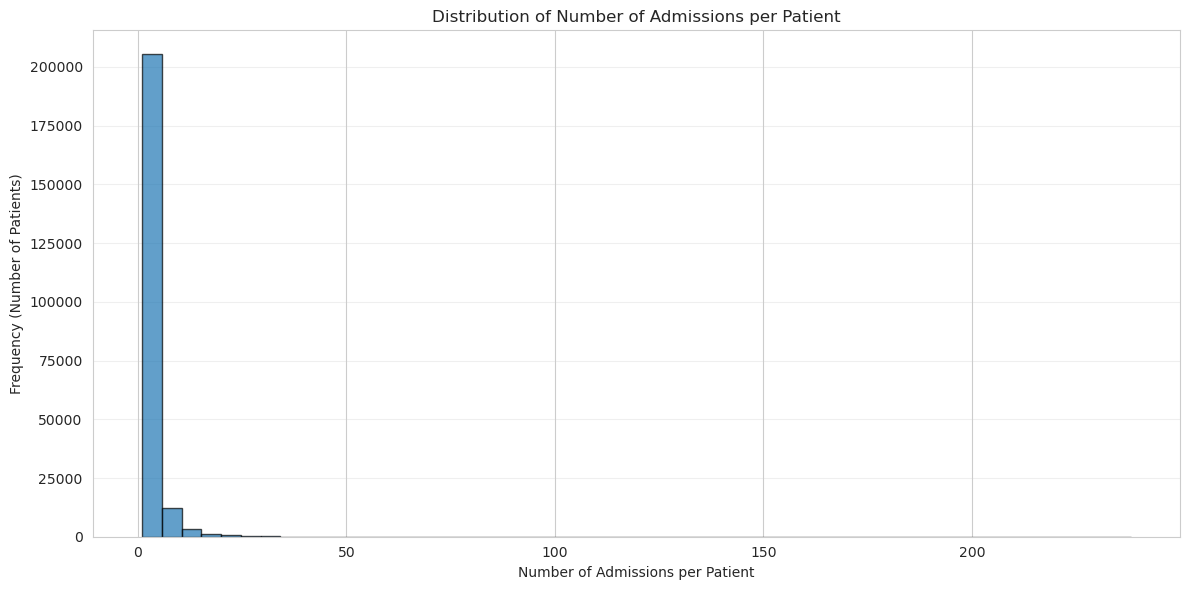

In [7]:
# Visualization: Histogram of admissions per patient
plt.figure(figsize=(12, 6))
plt.hist(admissions_per_patient, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Number of Admissions per Patient')
plt.ylabel('Frequency (Number of Patients)')
plt.title('Distribution of Number of Admissions per Patient')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Section 3: Laboratory Events Exploration

Analyze laboratory test events. The `labevents` table is large, so we use chunk processing.

In [8]:
# Load d_labitems dictionary for mapping itemid to label
print("Loading d_labitems dictionary...")
d_labitems_df = pd.read_csv(d_labitems_file)
print(f"Total lab items in dictionary: {len(d_labitems_df)}")

# Create mapping from itemid to label
labitem_map = dict(zip(d_labitems_df['itemid'], d_labitems_df['label']))
print(f"Mapping created for {len(labitem_map)} lab items.")

Loading d_labitems dictionary...
Total lab items in dictionary: 1650
Mapping created for 1650 lab items.


In [9]:
# Read labevents in chunks and aggregate (combined analysis)
print("\nReading labevents file in chunks...")
chunk_size = 1000000
lab_events_per_admission = defaultdict(int)
itemid_frequency = defaultdict(int)
repetition_counts = Counter()  # NEW: Added to avoid re-reading file later
chunk_number = 0

for chunk in pd.read_csv(
    labevents_file,
    usecols=['hadm_id', 'itemid'],
    chunksize=chunk_size
):
    chunk_number += 1
    print(f"Processing chunk {chunk_number}... ({len(chunk):,} rows)")
    
    # Remove rows with missing hadm_id
    chunk = chunk.dropna(subset=['hadm_id'])
    
    # Count lab events per admission
    for hadm_id in chunk['hadm_id']:
        lab_events_per_admission[hadm_id] += 1
    
    # Count frequency of each itemid
    itemid_counts = chunk['itemid'].value_counts()
    for itemid, count in itemid_counts.items():
        itemid_frequency[itemid] += count
    
    # NEW: Group by (hadm_id, itemid) and count occurrences for repetition analysis
    chunk_counts = chunk.groupby(['hadm_id', 'itemid']).size()
    repetition_counts.update(chunk_counts.to_dict())  # Convert Series to dict for proper tuple keys

print(f"\nTotal chunks processed: {chunk_number}")
print(f"Total admissions with lab events: {len(lab_events_per_admission):,}")
print(f"Unique lab test types: {len(itemid_frequency):,}")
print(f"Total unique (admission, test) pairs: {len(repetition_counts):,}")


Reading labevents file in chunks...
Processing chunk 1... (1,000,000 rows)
Processing chunk 2... (1,000,000 rows)
Processing chunk 3... (1,000,000 rows)
Processing chunk 4... (1,000,000 rows)
Processing chunk 5... (1,000,000 rows)
Processing chunk 6... (1,000,000 rows)
Processing chunk 7... (1,000,000 rows)
Processing chunk 8... (1,000,000 rows)
Processing chunk 9... (1,000,000 rows)
Processing chunk 10... (1,000,000 rows)
Processing chunk 11... (1,000,000 rows)
Processing chunk 12... (1,000,000 rows)
Processing chunk 13... (1,000,000 rows)
Processing chunk 14... (1,000,000 rows)
Processing chunk 15... (1,000,000 rows)
Processing chunk 16... (1,000,000 rows)
Processing chunk 17... (1,000,000 rows)
Processing chunk 18... (1,000,000 rows)
Processing chunk 19... (1,000,000 rows)
Processing chunk 20... (1,000,000 rows)
Processing chunk 21... (1,000,000 rows)
Processing chunk 22... (1,000,000 rows)
Processing chunk 23... (1,000,000 rows)
Processing chunk 24... (1,000,000 rows)
Processing c

In [10]:
# Calculate statistics for lab events per admission
lab_events_counts = list(lab_events_per_admission.values())
min_lab_events = min(lab_events_counts)
max_lab_events = max(lab_events_counts)
avg_lab_events = np.mean(lab_events_counts)

print("=" * 80)
print("LAB EVENTS PER ADMISSION:")
print(f"  Minimum: {min_lab_events}")
print(f"  Maximum: {max_lab_events}")
print(f"  Average: {avg_lab_events:.2f}")
print("=" * 80)

LAB EVENTS PER ADMISSION:
  Minimum: 1
  Maximum: 21655
  Average: 188.98


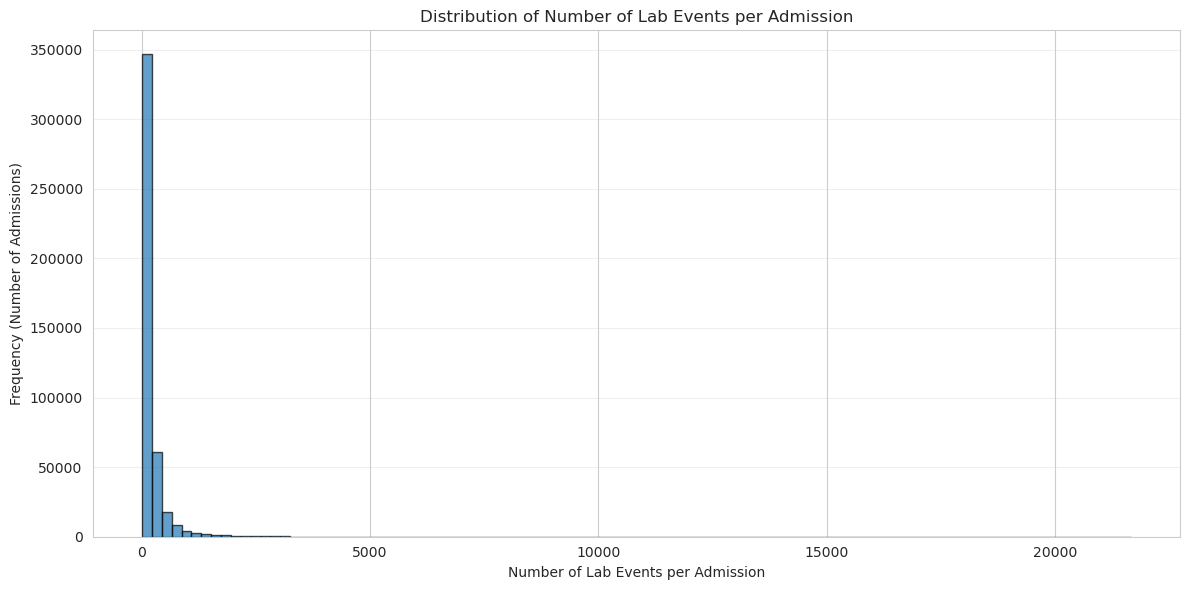

In [11]:
# Visualization 1: Histogram of lab events per admission
plt.figure(figsize=(12, 6))
plt.hist(lab_events_counts, bins=100, edgecolor='black', alpha=0.7)
plt.xlabel('Number of Lab Events per Admission')
plt.ylabel('Frequency (Number of Admissions)')
plt.title('Distribution of Number of Lab Events per Admission')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [12]:
# Get top 20 most frequent lab tests
top_20_labitems = sorted(itemid_frequency.items(), key=lambda x: x[1], reverse=True)[:20]

# Map itemids to labels
top_20_labels = []
top_20_counts = []
for itemid, count in top_20_labitems:
    label = labitem_map.get(itemid, f"Unknown ({itemid})")
    top_20_labels.append(label)
    top_20_counts.append(count)

print("\nTOP 20 MOST FREQUENT LAB TESTS:")
for i, (label, count) in enumerate(zip(top_20_labels, top_20_counts), 1):
    print(f"{i:2d}. {label:50s} - {count:,} occurrences")


TOP 20 MOST FREQUENT LAB TESTS:
 1. Potassium                                          - 2,648,172 occurrences
 2. Sodium                                             - 2,625,912 occurrences
 3. Chloride                                           - 2,601,418 occurrences
 4. Creatinine                                         - 2,587,046 occurrences
 5. Hematocrit                                         - 2,580,696 occurrences
 6. Urea Nitrogen                                      - 2,568,501 occurrences
 7. Bicarbonate                                        - 2,547,064 occurrences
 8. Anion Gap                                          - 2,541,356 occurrences
 9. Glucose                                            - 2,517,646 occurrences
10. Platelet Count                                     - 2,468,141 occurrences
11. Hemoglobin                                         - 2,442,997 occurrences
12. White Blood Cells                                  - 2,427,187 occurrences
13. MCHC           

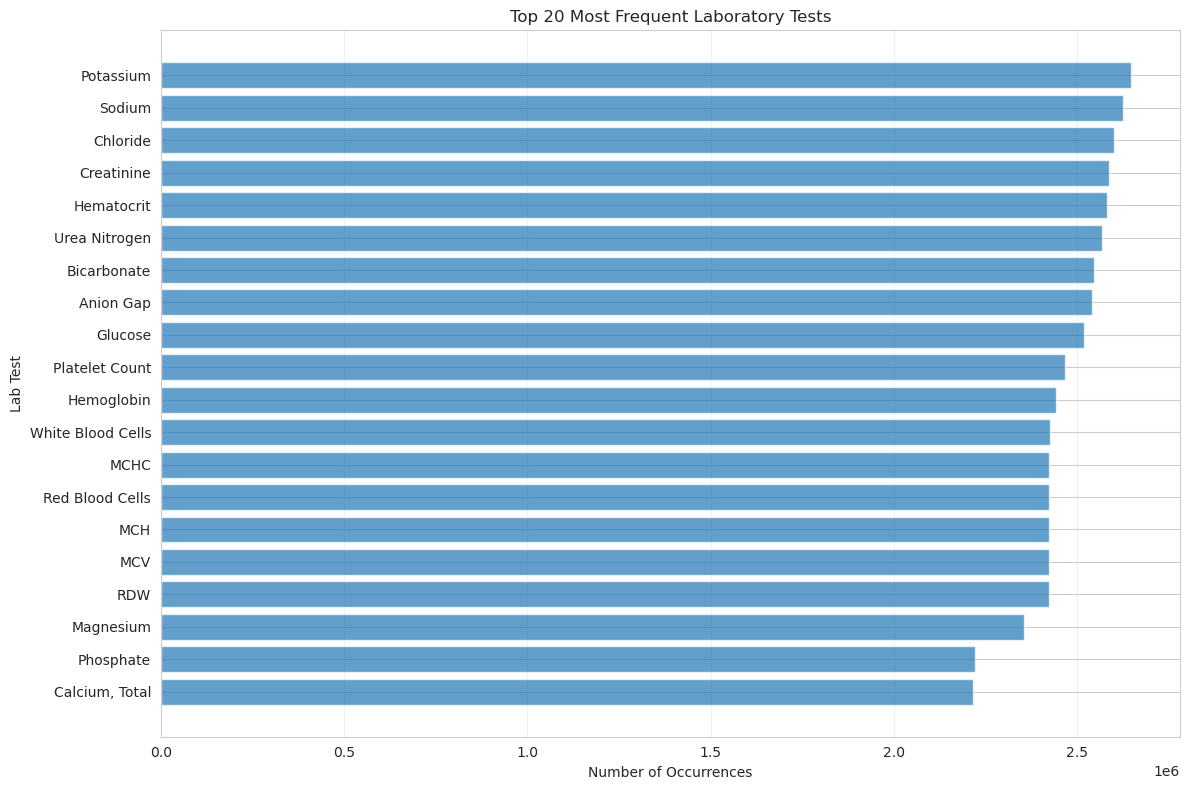

In [13]:
# Visualization 2: Horizontal bar chart of top 20 lab tests
plt.figure(figsize=(12, 8))
y_pos = np.arange(len(top_20_labels))
plt.barh(y_pos, top_20_counts, alpha=0.7)
plt.yticks(y_pos, top_20_labels)
plt.xlabel('Number of Occurrences')
plt.ylabel('Lab Test')
plt.title('Top 20 Most Frequent Laboratory Tests')
plt.gca().invert_yaxis()  # Highest at the top
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## Section 3.1: Laboratory Test Repetition Frequency Analysis

Analyze how frequently each laboratory test is repeated per admission. This analysis helps distinguish between static features (measured once) and time-series features (measured repeatedly), which is essential for the P-CAFE/MDP framework.

In [14]:
# Analyze repetition frequency of laboratory tests per admission
print("\nAnalyzing laboratory test repetition frequency...")
print("This analysis counts how many times each specific test (itemid) appears within a single admission (hadm_id).")
print("Note: The repetition_counts data was already computed during the initial file read to avoid redundant processing.\n")
print(f"Total unique (admission, test) pairs: {len(repetition_counts):,}")


Analyzing laboratory test repetition frequency...
This analysis counts how many times each specific test (itemid) appears within a single admission (hadm_id).
Note: The repetition_counts data was already computed during the initial file read to avoid redundant processing.

Total unique (admission, test) pairs: 20,364,828


In [15]:
# Create a DataFrame from the repetition counts
print("\nCreating repetition_stats DataFrame...")
repetition_stats = pd.DataFrame([
    {'hadm_id': hadm_id, 'itemid': itemid, 'count': count}
    for (hadm_id, itemid), count in repetition_counts.items()
])

print(f"DataFrame created with {len(repetition_stats):,} rows")
print(f"\nFirst few rows:")
print(repetition_stats.head(10))


Creating repetition_stats DataFrame...
DataFrame created with 20,364,828 rows

First few rows:
      hadm_id  itemid  count
0  20010003.0   50861      2
1  20010003.0   50862      2
2  20010003.0   50863      2
3  20010003.0   50868     10
4  20010003.0   50878      2
5  20010003.0   50882     10
6  20010003.0   50885      2
7  20010003.0   50893      8
8  20010003.0   50902     10
9  20010003.0   50911      2


In [16]:
# Calculate summary statistics for repetitions per test per admission
mean_repetitions = repetition_stats['count'].mean()
median_repetitions = repetition_stats['count'].median()
max_repetitions = repetition_stats['count'].max()

print("=" * 80)
print("LABORATORY TEST REPETITION FREQUENCY STATISTICS")
print("=" * 80)
print(f"Mean repetitions per test per admission:   {mean_repetitions:.2f}")
print(f"Median repetitions per test per admission: {median_repetitions:.0f}")
print(f"Max repetitions per test per admission:    {max_repetitions}")
print("=" * 80)

LABORATORY TEST REPETITION FREQUENCY STATISTICS
Mean repetitions per test per admission:   4.15
Median repetitions per test per admission: 2
Max repetitions per test per admission:    1239


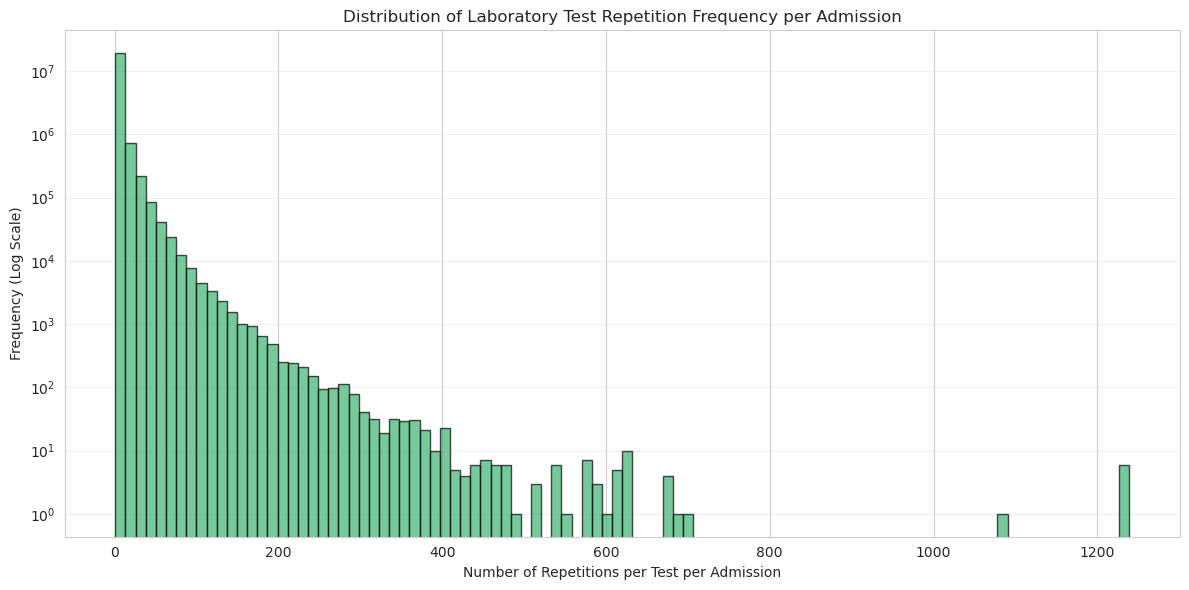

In [17]:
# Visualization: Histogram of repetitions per test per admission
plt.figure(figsize=(12, 6))
plt.hist(repetition_stats['count'], bins=100, edgecolor='black', alpha=0.7, color='mediumseagreen')
plt.xlabel('Number of Repetitions per Test per Admission')
plt.ylabel('Frequency (Log Scale)')
plt.title('Distribution of Laboratory Test Repetition Frequency per Admission')
plt.yscale('log')  # Use log scale for Y-axis due to highly skewed distribution
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [18]:
# Identify top 20 tests with highest average repetition count
print("\nCalculating average repetitions per test (itemid)...")
avg_repetitions_per_test = repetition_stats.groupby('itemid')['count'].mean().sort_values(ascending=False)
top_20_repeated = avg_repetitions_per_test.head(20)

# Join with d_labitems to get test names
top_20_repeated_df = pd.DataFrame({
    'itemid': top_20_repeated.index,
    'avg_repetitions': top_20_repeated.values
})

# Merge with d_labitems to get labels
top_20_repeated_df = top_20_repeated_df.merge(
    d_labitems_df[['itemid', 'label']], 
    on='itemid', 
    how='left'
)

# Fill missing labels
top_20_repeated_df['label'] = top_20_repeated_df.apply(
    lambda row: row['label'] if pd.notna(row['label']) else f"Unknown ({int(row['itemid'])})",
    axis=1
)

print("\nTOP 20 LABORATORY TESTS WITH HIGHEST AVERAGE REPETITION COUNT:")
print("=" * 80)
for i, row in top_20_repeated_df.iterrows():
    print(f"{i+1:2d}. {row['label']:50s} - Avg: {row['avg_repetitions']:.2f} repetitions/admission")
print("=" * 80)


Calculating average repetitions per test (itemid)...

TOP 20 LABORATORY TESTS WITH HIGHEST AVERAGE REPETITION COUNT:
 1. Heparin                                            - Avg: 8.75 repetitions/admission
 2. L                                                  - Avg: 8.31 repetitions/admission
 3. H                                                  - Avg: 8.31 repetitions/admission
 4. I                                                  - Avg: 8.31 repetitions/admission
 5. Blasts                                             - Avg: 8.17 repetitions/admission
 6. Specimen Type                                      - Avg: 7.89 repetitions/admission
 7. pH                                                 - Avg: 7.81 repetitions/admission
 8. pO2                                                - Avg: 7.67 repetitions/admission
 9. pCO2                                               - Avg: 7.67 repetitions/admission
10. Base Excess                                        - Avg: 7.67 repetitions/ad

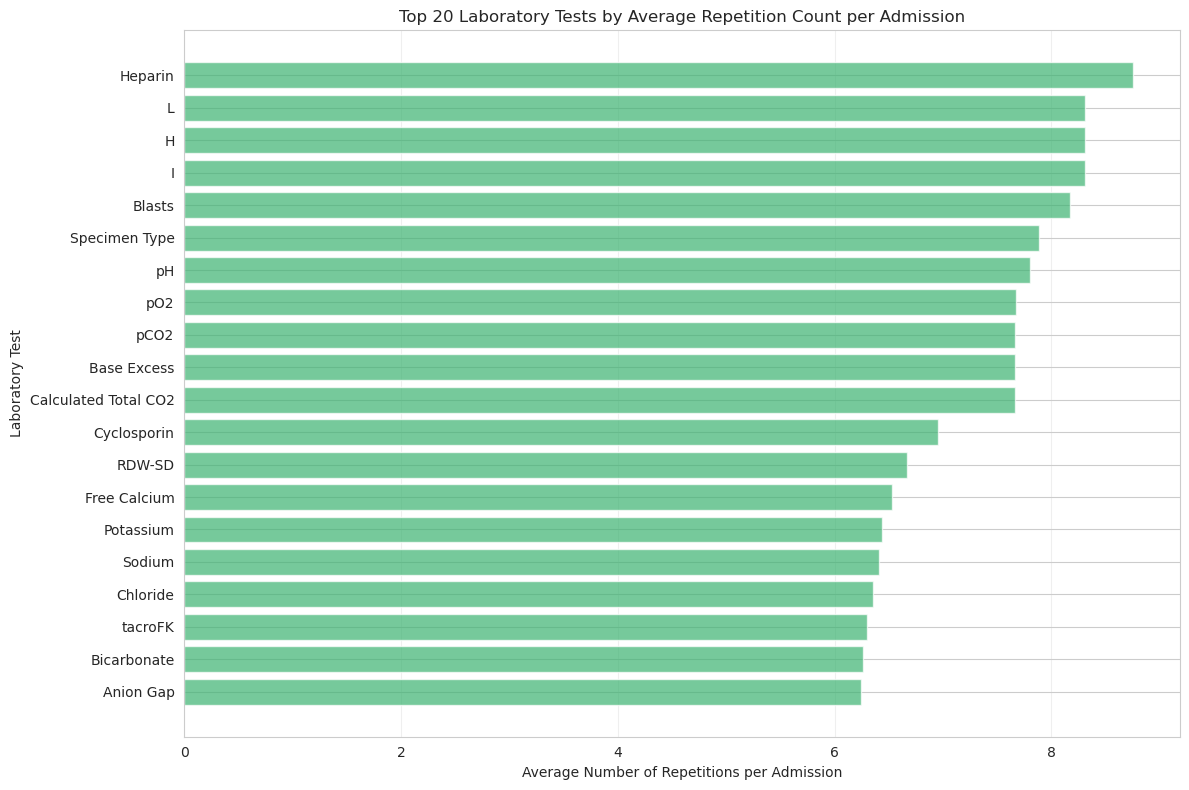

In [19]:
# Visualization: Bar chart of top 20 tests by average repetition count
plt.figure(figsize=(12, 8))
y_pos = np.arange(len(top_20_repeated_df))
plt.barh(y_pos, top_20_repeated_df['avg_repetitions'], alpha=0.7, color='mediumseagreen')
plt.yticks(y_pos, top_20_repeated_df['label'])
plt.xlabel('Average Number of Repetitions per Admission')
plt.ylabel('Laboratory Test')
plt.title('Top 20 Laboratory Tests by Average Repetition Count per Admission')
plt.gca().invert_yaxis()  # Highest at the top
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## Section 4: Microbiology Events Exploration

Analyze microbiology test events including cultures and susceptibility tests.

In [20]:
# Load microbiologyevents table
print("Loading microbiologyevents table...")
micro_df = pd.read_csv(microbiologyevents_file)
print(f"Microbiology events loaded: {len(micro_df):,} rows")
print(f"Columns: {list(micro_df.columns)}")

Loading microbiologyevents table...


/tmp/ipykernel_3256846/4146072705.py:3: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  micro_df = pd.read_csv(microbiologyevents_file)


Microbiology events loaded: 3,988,224 rows
Columns: ['microevent_id', 'subject_id', 'hadm_id', 'micro_specimen_id', 'order_provider_id', 'chartdate', 'charttime', 'spec_itemid', 'spec_type_desc', 'test_seq', 'storedate', 'storetime', 'test_itemid', 'test_name', 'org_itemid', 'org_name', 'isolate_num', 'quantity', 'ab_itemid', 'ab_name', 'dilution_text', 'dilution_comparison', 'dilution_value', 'interpretation', 'comments']


In [21]:
# Remove rows with missing hadm_id
micro_df = micro_df.dropna(subset=['hadm_id'])
print(f"After removing missing hadm_id: {len(micro_df):,} rows")

After removing missing hadm_id: 1,759,881 rows


In [22]:
# Count microbiology events per admission
micro_events_per_admission = micro_df.groupby('hadm_id').size()

min_micro_events = micro_events_per_admission.min()
max_micro_events = micro_events_per_admission.max()
avg_micro_events = micro_events_per_admission.mean()

print("=" * 80)
print("MICROBIOLOGY EVENTS PER ADMISSION:")
print(f"  Minimum: {min_micro_events}")
print(f"  Maximum: {max_micro_events}")
print(f"  Average: {avg_micro_events:.2f}")
print("=" * 80)

MICROBIOLOGY EVENTS PER ADMISSION:
  Minimum: 1
  Maximum: 514
  Average: 8.75


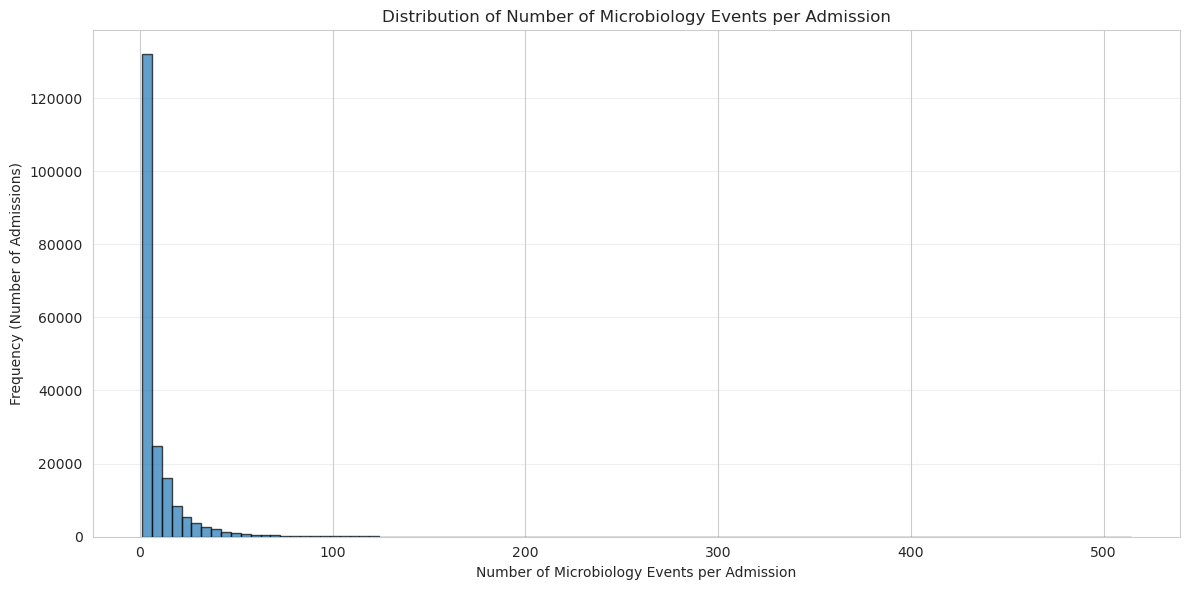

In [23]:
# Visualization 1: Histogram of microbiology events per admission
plt.figure(figsize=(12, 6))
plt.hist(micro_events_per_admission, bins=100, edgecolor='black', alpha=0.7)
plt.xlabel('Number of Microbiology Events per Admission')
plt.ylabel('Frequency (Number of Admissions)')
plt.title('Distribution of Number of Microbiology Events per Admission')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [24]:
# Create combined test name from test_name and spec_type_desc
micro_df['combined_test'] = micro_df.apply(
    lambda row: f"{row['test_name']} - {row['spec_type_desc']}" 
    if pd.notna(row['spec_type_desc']) and pd.notna(row['test_name'])
    else (row['test_name'] if pd.notna(row['test_name']) else 'Unknown'),
    axis=1
)

# Count frequency of each test
test_frequency = micro_df['combined_test'].value_counts()
top_20_micro_tests = test_frequency.head(20)

print("\nTOP 20 MOST FREQUENT MICROBIOLOGY TESTS:")
for i, (test_name, count) in enumerate(top_20_micro_tests.items(), 1):
    print(f"{i:2d}. {test_name:60s} - {count:,} occurrences")


TOP 20 MOST FREQUENT MICROBIOLOGY TESTS:
 1. Blood Culture, Routine - BLOOD CULTURE                       - 400,602 occurrences
 2. URINE CULTURE - URINE                                        - 280,973 occurrences
 3. RESPIRATORY CULTURE - SPUTUM                                 - 113,648 occurrences
 4. WOUND CULTURE - SWAB                                         - 69,541 occurrences
 5. MRSA SCREEN - MRSA SCREEN                                    - 67,650 occurrences
 6. TISSUE - TISSUE                                              - 58,181 occurrences
 7. GRAM STAIN - SPUTUM                                          - 44,481 occurrences
 8. REFLEX URINE CULTURE - URINE                                 - 33,732 occurrences
 9. C. difficile PCR - STOOL                                     - 24,610 occurrences
10. FLUID CULTURE - ABSCESS                                      - 22,657 occurrences
11. RESPIRATORY CULTURE - BRONCHOALVEOLAR LAVAGE                 - 21,582 occurrences
12. CLOST

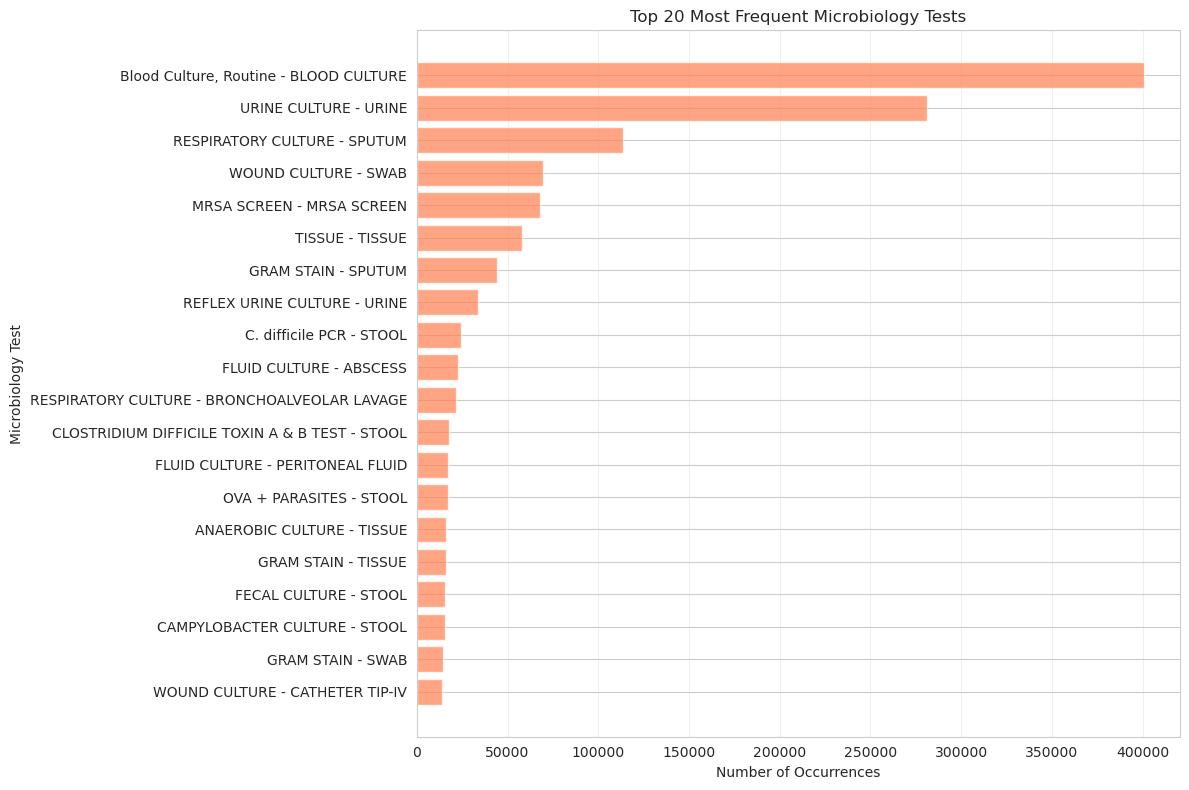

In [25]:
# Visualization 2: Horizontal bar chart of top 20 microbiology tests
plt.figure(figsize=(12, 8))
y_pos = np.arange(len(top_20_micro_tests))
plt.barh(y_pos, top_20_micro_tests.values, alpha=0.7, color='coral')
plt.yticks(y_pos, top_20_micro_tests.index)
plt.xlabel('Number of Occurrences')
plt.ylabel('Microbiology Test')
plt.title('Top 20 Most Frequent Microbiology Tests')
plt.gca().invert_yaxis()  # Highest at the top
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## Section 5: Chart Events (Vitals) Exploration

Analyze chart events which contain vital signs and nursing observations. This is the largest table in MIMIC-IV.

In [26]:
# Load d_items dictionary for mapping itemid to label
print("Loading d_items dictionary...")
d_items_df = pd.read_csv(d_items_file)
print(f"Total chart items in dictionary: {len(d_items_df)}")

# Create mapping from itemid to label
chartitem_map = dict(zip(d_items_df['itemid'], d_items_df['label']))
print(f"Mapping created for {len(chartitem_map)} chart items.")

Loading d_items dictionary...
Total chart items in dictionary: 4095
Mapping created for 4095 chart items.


In [27]:
# Read chartevents in chunks and count itemid frequency
print("\nReading chartevents file in chunks (this may take a while)...")
chunk_size = 1000000
chart_itemid_frequency = defaultdict(int)
chunk_number = 0

for chunk in pd.read_csv(
    chartevents_file,
    usecols=['itemid'],
    chunksize=chunk_size
):
    chunk_number += 1
    print(f"Processing chunk {chunk_number}... ({len(chunk):,} rows)")
    
    # Count frequency of each itemid
    itemid_counts = chunk['itemid'].value_counts()
    for itemid, count in itemid_counts.items():
        chart_itemid_frequency[itemid] += count

print(f"\nTotal chunks processed: {chunk_number}")
print(f"Unique chart event types: {len(chart_itemid_frequency):,}")


Reading chartevents file in chunks (this may take a while)...
Processing chunk 1... (1,000,000 rows)
Processing chunk 2... (1,000,000 rows)
Processing chunk 3... (1,000,000 rows)
Processing chunk 4... (1,000,000 rows)
Processing chunk 5... (1,000,000 rows)
Processing chunk 6... (1,000,000 rows)
Processing chunk 7... (1,000,000 rows)
Processing chunk 8... (1,000,000 rows)
Processing chunk 9... (1,000,000 rows)
Processing chunk 10... (1,000,000 rows)
Processing chunk 11... (1,000,000 rows)
Processing chunk 12... (1,000,000 rows)
Processing chunk 13... (1,000,000 rows)
Processing chunk 14... (1,000,000 rows)
Processing chunk 15... (1,000,000 rows)
Processing chunk 16... (1,000,000 rows)
Processing chunk 17... (1,000,000 rows)
Processing chunk 18... (1,000,000 rows)
Processing chunk 19... (1,000,000 rows)
Processing chunk 20... (1,000,000 rows)
Processing chunk 21... (1,000,000 rows)
Processing chunk 22... (1,000,000 rows)
Processing chunk 23... (1,000,000 rows)
Processing chunk 24... (1,

In [28]:
# Get top 20 most frequent chart events
top_20_chartitems = sorted(chart_itemid_frequency.items(), key=lambda x: x[1], reverse=True)[:20]

# Map itemids to labels
top_20_chart_labels = []
top_20_chart_counts = []
for itemid, count in top_20_chartitems:
    label = chartitem_map.get(itemid, f"Unknown ({itemid})")
    top_20_chart_labels.append(label)
    top_20_chart_counts.append(count)

print("\nTOP 20 MOST FREQUENT CHART EVENTS (VITALS/OBSERVATIONS):")
for i, (label, count) in enumerate(zip(top_20_chart_labels, top_20_chart_counts), 1):
    print(f"{i:2d}. {label:50s} - {count:,} occurrences")


TOP 20 MOST FREQUENT CHART EVENTS (VITALS/OBSERVATIONS):
 1. Safety Measures                                    - 12,869,833 occurrences
 2. Heart Rate                                         - 8,752,069 occurrences
 3. Respiratory Rate                                   - 8,636,655 occurrences
 4. O2 saturation pulseoxymetry                        - 8,567,015 occurrences
 5. Heart Rhythm                                       - 7,947,289 occurrences
 6. Ectopy Type 1                                      - 7,049,295 occurrences
 7. Non Invasive Blood Pressure systolic               - 5,378,740 occurrences
 8. Non Invasive Blood Pressure diastolic              - 5,377,689 occurrences
 9. Non Invasive Blood Pressure mean                   - 5,372,922 occurrences
10. Less Restrictive Measures                          - 5,021,996 occurrences
11. Orientation                                        - 3,386,834 occurrences
12. Head of Bed                                        - 3,357,599 occur

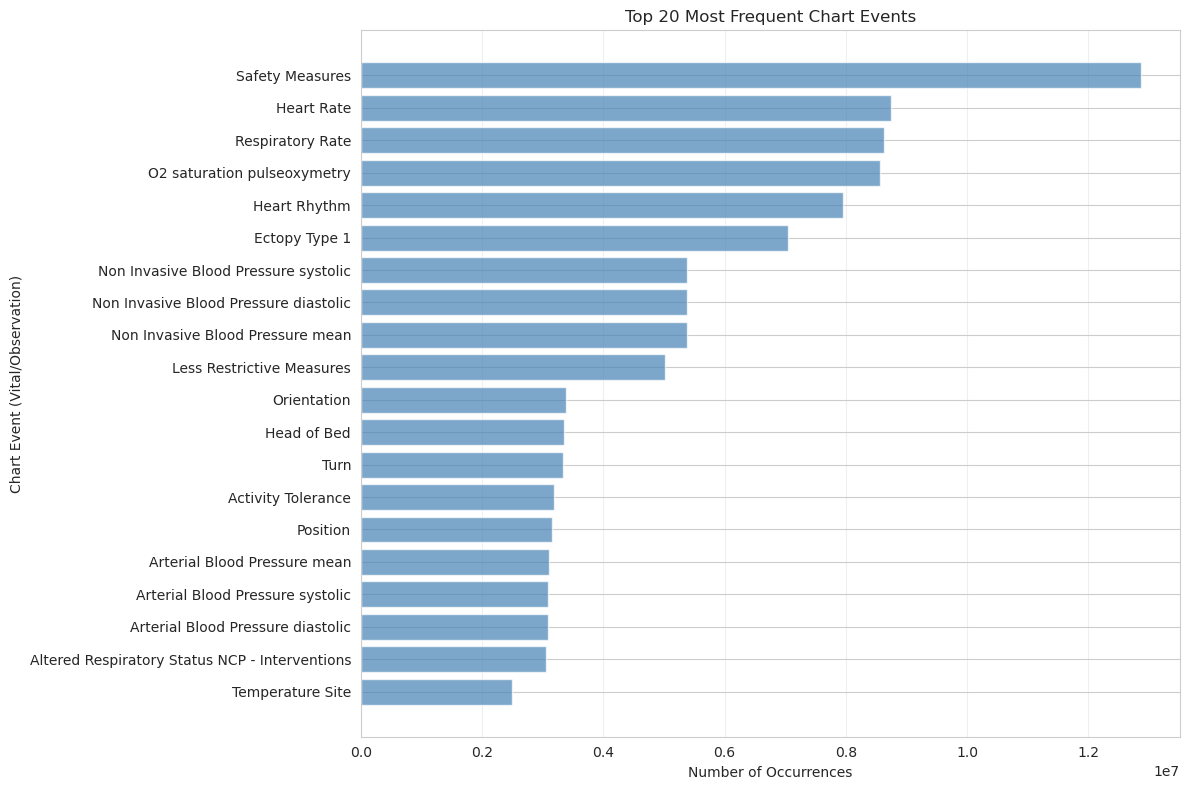

In [29]:
# Visualization: Horizontal bar chart of top 20 chart events
plt.figure(figsize=(12, 8))
y_pos = np.arange(len(top_20_chart_labels))
plt.barh(y_pos, top_20_chart_counts, alpha=0.7, color='steelblue')
plt.yticks(y_pos, top_20_chart_labels)
plt.xlabel('Number of Occurrences')
plt.ylabel('Chart Event (Vital/Observation)')
plt.title('Top 20 Most Frequent Chart Events')
plt.gca().invert_yaxis()  # Highest at the top
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## Section 6: Demographic Feature Vector Extraction

Extract compact demographic features per admission for the RL agent (P-CAFE).
Creates a Parquet file with columns: `subject_id`, `hadm_id`, `demographic_vec`.
`demographic_vec` is a list of 4 numbers: [Age (float), Gender (int: 0=M, 1=F), Height (cm, float), Weight (kg, float)].

In [30]:
# Load core patient and admission data
print("Loading patient and admission data for demographic features...")

# Load patients table
patients_demo = pd.read_csv(patients_file, usecols=['subject_id', 'gender', 'anchor_age', 'anchor_year'])
print(f"Patients loaded: {len(patients_demo)} rows")

# Load admissions table
admissions_demo = pd.read_csv(admissions_file, usecols=['subject_id', 'hadm_id', 'admittime'])
print(f"Admissions loaded: {len(admissions_demo)} rows")

# Merge patients and admissions
demo_df = admissions_demo.merge(patients_demo, on='subject_id', how='left')

# Calculate admission age
demo_df['admittime'] = pd.to_datetime(demo_df['admittime'])
demo_df['admit_year'] = demo_df['admittime'].dt.year
demo_df['admission_age'] = demo_df['anchor_age'] + (demo_df['admit_year'] - demo_df['anchor_year'])

# Encode gender as binary (M=0, F=1)
demo_df['gender_encoded'] = demo_df['gender'].map({'M': 0, 'F': 1})

print(f"\nMerged demographic data: {len(demo_df)} rows")
print(f"Age range: {demo_df['admission_age'].min():.1f} - {demo_df['admission_age'].max():.1f}")
print(f"Gender distribution: {demo_df['gender'].value_counts().to_dict()}")

Loading patient and admission data for demographic features...
Patients loaded: 364627 rows
Admissions loaded: 546028 rows

Merged demographic data: 546028 rows
Age range: 18.0 - 106.0
Gender distribution: {'F': 284097, 'M': 261931}


In [31]:
# Extract Height and Weight from chartevents using chunked processing
print("\nExtracting Height and Weight from chartevents (chunked processing)...")

# Target ItemIDs
HEIGHT_ITEMID = 226730  # Height (cm)
WEIGHT_ITEMID = 226512  # Admission Weight (kg)
target_itemids = [HEIGHT_ITEMID, WEIGHT_ITEMID]

# Dictionary to store first valid measurement per hadm_id
height_data = {}  # hadm_id -> height
weight_data = {}  # hadm_id -> weight

chunk_size = 1000000
chunk_number = 0
total_height_found = 0
total_weight_found = 0

for chunk in pd.read_csv(
    chartevents_file,
    usecols=['hadm_id', 'itemid', 'valuenum'],
    chunksize=chunk_size
):
    chunk_number += 1
    if chunk_number % 50 == 0:
        print(f"Processing chunk {chunk_number}... (Height: {total_height_found}, Weight: {total_weight_found})")
    
    # Filter for target itemids
    chunk_filtered = chunk[chunk['itemid'].isin(target_itemids)].copy()
    
    # Remove rows with missing hadm_id or valuenum
    chunk_filtered = chunk_filtered.dropna(subset=['hadm_id', 'valuenum'])
    
    if len(chunk_filtered) == 0:
        continue
    
    # Convert hadm_id to int
    chunk_filtered['hadm_id'] = chunk_filtered['hadm_id'].astype(int)
    
    # Process height measurements
    height_rows = chunk_filtered[chunk_filtered['itemid'] == HEIGHT_ITEMID]
    for _, row in height_rows.iterrows():
        hadm_id = row['hadm_id']
        if hadm_id not in height_data and row['valuenum'] > 0:  # Take first valid measurement
            height_data[hadm_id] = row['valuenum']
            total_height_found += 1
    
    # Process weight measurements
    weight_rows = chunk_filtered[chunk_filtered['itemid'] == WEIGHT_ITEMID]
    for _, row in weight_rows.iterrows():
        hadm_id = row['hadm_id']
        if hadm_id not in weight_data and row['valuenum'] > 0:  # Take first valid measurement
            weight_data[hadm_id] = row['valuenum']
            total_weight_found += 1

print(f"\nTotal chunks processed: {chunk_number}")
print(f"Height measurements found: {total_height_found}")
print(f"Weight measurements found: {total_weight_found}")

# Convert to DataFrames
height_df = pd.DataFrame(list(height_data.items()), columns=['hadm_id', 'height'])
weight_df = pd.DataFrame(list(weight_data.items()), columns=['hadm_id', 'weight'])

print(f"\nHeight data shape: {height_df.shape}")
print(f"Weight data shape: {weight_df.shape}")


Extracting Height and Weight from chartevents (chunked processing)...
Processing chunk 50... (Height: 4927, Weight: 9800)
Processing chunk 100... (Height: 9784, Weight: 19261)
Processing chunk 150... (Height: 14960, Weight: 29448)
Processing chunk 200... (Height: 19960, Weight: 39516)
Processing chunk 250... (Height: 24958, Weight: 49371)
Processing chunk 300... (Height: 29794, Weight: 59045)
Processing chunk 350... (Height: 34668, Weight: 68806)
Processing chunk 400... (Height: 39674, Weight: 78888)

Total chunks processed: 433
Height measurements found: 42902
Weight measurements found: 85166

Height data shape: (42902, 2)
Weight data shape: (85166, 2)


In [32]:
# Merge height and weight data back to demographic DataFrame
print("\nConsolidating demographic features...")

demo_df = demo_df.merge(height_df, on='hadm_id', how='left')
demo_df = demo_df.merge(weight_df, on='hadm_id', how='left')

print(f"\nBefore imputation:")
print(f"  Missing height: {demo_df['height'].isna().sum()} ({demo_df['height'].isna().sum()/len(demo_df)*100:.1f}%)")
print(f"  Missing weight: {demo_df['weight'].isna().sum()} ({demo_df['weight'].isna().sum()/len(demo_df)*100:.1f}%)")
print(f"  Missing age: {demo_df['admission_age'].isna().sum()}")
print(f"  Missing gender: {demo_df['gender_encoded'].isna().sum()}")

# Impute missing values with median
height_median = demo_df['height'].median()
weight_median = demo_df['weight'].median()
demo_df['height'].fillna(height_median, inplace=True)
demo_df['weight'].fillna(weight_median, inplace=True)

# For any remaining missing values in age/gender (should be rare), fill with reasonable defaults
age_median = demo_df['admission_age'].median()
demo_df['admission_age'].fillna(age_median, inplace=True)
demo_df['gender_encoded'].fillna(0, inplace=True)  # Default to M=0 if missing

print(f"\nAfter imputation:")
print(f"  Missing height: {demo_df['height'].isna().sum()}")
print(f"  Missing weight: {demo_df['weight'].isna().sum()}")
print(f"  Missing age: {demo_df['admission_age'].isna().sum()}")
print(f"  Missing gender: {demo_df['gender_encoded'].isna().sum()}")

print(f"\nImputation values used:")
print(f"  Height median: {height_median:.1f} cm")
print(f"  Weight median: {weight_median:.1f} kg")
print(f"  Age median: {age_median:.1f} years")


Consolidating demographic features...

Before imputation:
  Missing height: 503126 (92.1%)
  Missing weight: 460862 (84.4%)
  Missing age: 0
  Missing gender: 0

After imputation:
  Missing height: 0
  Missing weight: 0
  Missing age: 0
  Missing gender: 0

Imputation values used:
  Height median: 170.0 cm
  Weight median: 78.0 kg
  Age median: 61.0 years


/tmp/ipykernel_3256846/700909397.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  demo_df['height'].fillna(height_median, inplace=True)
/tmp/ipykernel_3256846/700909397.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=T

In [33]:
# Create demographic_vec column
print("\nCreating demographic feature vectors...")

# Create vector: [age, gender_encoded, height, weight]
demo_df['demographic_vec'] = demo_df.apply(
    lambda row: [row['admission_age'], row['gender_encoded'], row['height'], row['weight']],
    axis=1
)

# Select final columns
output_df = demo_df[['subject_id', 'hadm_id', 'demographic_vec']].copy()

# Save to Parquet
output_file = '../data/output/demographic_features.parquet'
output_df.to_parquet(output_file, index=False)

print(f"\nDemographic features saved to: {output_file}")
print(f"Output shape: {output_df.shape}")
print(f"\nFirst 5 rows:")
print(output_df.head())

# Verify vector format
sample_vec = output_df['demographic_vec'].iloc[0]
print(f"\nSample demographic_vec: {sample_vec}")
print(f"Vector length: {len(sample_vec)}")
print(f"Vector format: [Age={sample_vec[0]:.1f}, Gender={sample_vec[1]}, Height={sample_vec[2]:.1f}cm, Weight={sample_vec[3]:.1f}kg]")


Creating demographic feature vectors...

Demographic features saved to: ../data/output/demographic_features.parquet
Output shape: (546028, 3)

First 5 rows:
   subject_id   hadm_id       demographic_vec
0    10000032  22595853  [52, 1, 170.0, 78.0]
1    10000032  22841357  [52, 1, 170.0, 78.0]
2    10000032  25742920  [52, 1, 170.0, 78.0]
3    10000032  29079034  [52, 1, 152.0, 39.4]
4    10000068  25022803  [19, 1, 170.0, 78.0]

Sample demographic_vec: [52, 1, 170.0, 78.0]
Vector length: 4
Vector format: [Age=52.0, Gender=1, Height=170.0cm, Weight=78.0kg]


## Summary

This notebook has successfully performed comprehensive exploratory data analysis on MIMIC-IV data:

1. ✅ **Setup & Configuration**: Imported pandas, matplotlib, seaborn; set readable plot style; defined file paths
2. ✅ **Patient & Admission Statistics**: Calculated total patients, admissions, and admissions per patient; created histogram
3. ✅ **Laboratory Events**: Used chunk processing to analyze lab events; calculated statistics; created 2 visualizations (histogram and top 20 bar chart)
4. ✅ **Microbiology Events**: Analyzed microbiology tests; calculated statistics; created 2 visualizations (histogram and top 20 bar chart)
5. ✅ **Chart Events (Vitals)**: Used chunk processing to analyze the largest table; created top 20 visualization
6. ✅ **Demographic Feature Vector Extraction**: Created compact demographic feature vectors per admission (age, gender, height, weight) and saved to Parquet format for P-CAFE RL agent.

All visualizations include proper titles, axis labels, and are sized appropriately for readability. The chunking strategy successfully handles the massive `labevents` and `chartevents` tables without memory issues.